# <font color="#5fa8d3"> Yolo model


## <font color="#62b6cb"> Table of Content <a name="ToC"></a>
0. [Libraries Importation, Parameters & Funtions Definition](#id0)<br>
1. [Preparation of the data](#id1)<br>
    1.1 [Copy Images to Yolo Folder](#id11)<br>
    1.2 [Obtain the labels for YOLO](#id12)<br>


## <font color="#62b6cb"> 0. Libraries Importation, Parameters & Funtions Definition <a name="id0"></a>

In [1]:
# things to put in the config
'./Notebooks/data.yaml'

'./Notebooks/data.yaml'

In [2]:
import json
import os
from ultralytics import YOLO
import shutil
import yaml # for importing a yaml file
import joblib
import torch

In [3]:
current_directory = os.getcwd()
last_folder = os.path.basename(current_directory)
    
if last_folder != "project-danielteresa":
    while last_folder != "project-danielteresa":
        parent_directory = os.path.dirname(current_directory)
        last_folder = os.path.basename(parent_directory)

        os.chdir(parent_directory)
        print(f"Changed directory to: {parent_directory}")
else:
    print("Already in the project root directory.")

# our modules
from src.mymodule import * # for importing our functions

Changed directory to: c:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa


**Configuration Variables**

In [4]:
# Load the YAML file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Function to set variables globally and store their names
def set_variables(config, prefix='', var_dict={}):
    for key, value in config.items():
        if isinstance(value, dict):
            set_variables(value, prefix + key + '_', var_dict)
        else:
            globals()[prefix + key] = value
            var_dict[prefix + key] = value
    return var_dict

# Set variables globally and get a dictionary of the set variables
set_vars = set_variables(config)

# Print all the variables that were set
print("Variables set from YAML file:")
for var_name, var_value in set_vars.items():
    print(f"{var_name}: {var_value}")

Variables set from YAML file:
seed: 123
color1: #62b6cb
color2: #fb8500
color3: #023047
color4: #FFB703
path_annotations: ./Data
path_train: ./Data/train/original
path_train_train: ./Data/train/train
path_train_aug: ./Data/train/train_aug
path_train_val: ./Data/train/val
path_test: ./Data/test
path_yolo: ./Data/Yoloimages/
kaggle_train_annotations: annotations_train.json
train_annotations_name_temp: annotations_train_temp.json
train_annotations_name: annotations_train_updated.json
aug_train_annotations_name: annotations_train_updated_aug.json
val_annotations_name: annotations_val_updated.json
kaggle_test_annotations: annotations_test.json
test_annotations_name_temp: annotations_test_temp.json
test_annotations_name: annotations_test_updated.json
weights_yolo_path: Models/yolo_weights
runs_path: Models/runs


## <font color="#62b6cb"> 1. Preparation of data <a name="id1"></a>

### <font color="#62b6cb"> 1.1 Copy Images to Yolo Folder  <a name="id11"></a> 

In [4]:
# Create the folders if they don't exist
directories = [
    os.path.join(path_yolo, "train/images"),
    os.path.join(path_yolo, "train/labels"),
    os.path.join(path_yolo, "val/images"),
    os.path.join(path_yolo, "val/labels"),
    os.path.join(path_yolo, "test/images"),
    os.path.join(path_yolo, "test/labels")
]

for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Remove everything that exists in the folders
for directory in [    os.path.join(path_yolo, "train/images"),
                      os.path.join(path_yolo, "train/labels"),
                      os.path.join(path_yolo, "val/images"),
                      os.path.join(path_yolo, "val/labels"),
                      os.path.join(path_yolo, "test/images"),
                      os.path.join(path_yolo, "test/labels")]:
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove the directory and its contents
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

# Copy images from train augmented to Yolo train folder
shutil.copytree(path_train_aug, os.path.join(path_yolo, "train/images"), dirs_exist_ok=True)
shutil.copytree(path_train_val, os.path.join(path_yolo, "val/images"), dirs_exist_ok=True)
shutil.copytree(path_test, os.path.join(path_yolo, "test/images"), dirs_exist_ok=True)

print("Folders have been cleaned and files have been copied successfully.")

Folders have been cleaned and files have been copied successfully.


Check the annotations and id of the coco jsons

In [5]:
print("Check that annotation for training is correct")
print(validate_coco_dataset(os.path.join(path_annotations,aug_train_annotations_name), os.path.join(path_yolo,"train/images")))

print("Check that annotation for validation is correct")
print(validate_coco_dataset(os.path.join(path_annotations,val_annotations_name), os.path.join(path_yolo,"val/images")))

print("Check that annotation for test is correct")
print(validate_coco_dataset(os.path.join(path_annotations,test_annotations_name), os.path.join(path_yolo,"test/images")))

Check that annotation for training is correct
True
Check that annotation for validation is correct
True
Check that annotation for test is correct
True


Some of the points of the polygons are out of the range of the width and the height

In [6]:
# Some of the points of the polygons are out of the range of the images

# train
process_coco_annotations(os.path.join(path_annotations,aug_train_annotations_name),
                          os.path.join(path_annotations,aug_train_annotations_name))

# val
process_coco_annotations(os.path.join(os.path.join(path_annotations,val_annotations_name)), 
                         os.path.join(os.path.join(path_annotations,val_annotations_name)) )

### <font color="#62b6cb"> 1.2 Obtain the labels for YOLO  <a name="id12"></a> 

Obtain the yolo txt for each images from the coco data annotations using the conver_coco from ultralytics. The annotations json to convert should be in a folder with that json in it.

In [7]:
# Obtain the yolo labels
# train
convert_coco_to_yolo_segmentation(path_annotations, aug_train_annotations_name, path_yolo, 'train')
# val
convert_coco_to_yolo_segmentation(path_annotations, val_annotations_name, path_yolo, 'val')
# test
convert_coco_to_yolo_segmentation(path_annotations, test_annotations_name, path_yolo, 'test')

Annotations /home/sagemaker-user/project-danielteresa/Data/Yoloimages/train/annotations_train_updated_aug.json: 100%|██████████| 46485/46485 [00:22<00:00, 2031.49it/s]

COCO data converted successfully.
Results saved to /home/sagemaker-user/project-danielteresa/Data/Yoloimages/aux


Removed auxiliary directory ./Data/Yoloimages/aux
Yolo labels saved in ./Data/Yoloimages/train/labels



Annotations /home/sagemaker-user/project-danielteresa/Data/Yoloimages/val/annotations_val_updated.json: 100%|██████████| 2324/2324 [00:00<00:00, 11728.94it/s]

COCO data converted successfully.
Results saved to /home/sagemaker-user/project-danielteresa/Data/Yoloimages/aux


Removed auxiliary directory ./Data/Yoloimages/aux
Yolo labels saved in ./Data/Yoloimages/val/labels



Annotations /home/sagemaker-user/project-danielteresa/Data/Yoloimages/test/annotations_test_updated.json: 100%|██████████| 2324/2324 [00:00<00:00, 12081.64it/s]

COCO data converted successfully.
Results saved to /home/sagemaker-user/project-danielteresa/Data/Yoloimages/aux


Removed auxiliary directory ./Data/Yoloimages/aux
Yolo labels saved in ./Data/Yoloimages/test/labels



We check the nº of elememts in the folder:

In [6]:
# Define the directory path
directory_path = path_yolo+'/train/labels'

# List all files in the directory
files = os.listdir(directory_path)

# Count the number of files
file_count = len([file for file in files if os.path.isfile(os.path.join(directory_path, file))])

print(f"Number of files in '{directory_path}': {file_count}")

Number of files in './Data/Yoloimages//train/labels': 46485


We define a subset of images

In [16]:
# Folder Set up
train_folder = './Data/Yoloimages/train'
val_folder = './Data/Yoloimages/val'

destination_train_folder = './Data/Yoloimages/train_prueba'
destination_val_folder = './Data/Yoloimages/val_prueba'

# Seleccionar 20 imágenes de cada carpeta
select_images(train_folder, destination_train_folder, 2000, 'images', 'labels', seed)
select_images(val_folder, destination_val_folder, 2000, 'images', 'labels', seed)

The yaml file is created for the yolo code.

In [11]:
with open(os.path.join(path_annotations,val_annotations_name), 'r') as f:
    coco_data = json.load(f)

names = [class_name['name'] for class_name in coco_data["categories"]]

# Specify the paths and information
actual_path = os.getcwd()
train_path = os.path.join(actual_path, 'Data/Yoloimages/train_prueba/images')
val_path = os.path.join(actual_path, 'Data/Yoloimages/val_prueba/images')

names_categories = [class_name['name'] for class_name in coco_data["categories"]]
nc = len(names)
file_path = './Notebooks/data.yaml'

# Create the YAML file
create_yaml_file(file_path, train_path, val_path, nc, names)

We train the model or uploaded if it was already trained:

In [ ]:
# Path to save/load the model
model_path = "./Models/yolo_model.pkl"

# Fit the GLM with Gamma family and log link if it is not saved
if os.path.exists(model_path):
    print("Loading existing model...")
    yolo_model = joblib.load(model_path)
else:
    print("Training new model...")
    try:
        if not os.path.exists(weights_yolo_path):
            os.makedirs(weights_yolo_path)
        # Initialize the YOLO model with the specified weights
        yolo_model = YOLO(os.path.join(weights_yolo_path, "yolov8m-seg.pt"))
        
        # Train the YOLO model
        yolo_model.train(data="./Notebooks/data.yaml", 
                         batch=100,
                         epochs=10, 
                         optimizer='Adam', 
                         task='segment',
                         project=runs_path)
        # Save the model
        joblib.dump(yolo_model, model_path)
        print(f"Model saved to {model_path}")
    except Exception as e:
        print("Error fitting the model:", e)
        raise e

Training new model...


100%|██████████| 52.4M/52.4M [00:00<00:00, 83.4MB/s]


Ultralytics YOLOv8.2.70 🚀 Python-3.10.14 torch-2.0.0.post104 CPU (Intel Xeon Platinum 8488C)
engine/trainer: task=segment, mode=train, model=Models/yolo_weights/yolov8m-seg.pt, data=./Notebooks/data.yaml, epochs=10, time=None, patience=100, batch=100, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=Models/runs, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

train: Scanning /home/sagemaker-user/project-danielteresa/Data/Yoloimages/train_prueba/labels.cache... 1999 images, 0 backgrounds, 1 corrupt: 100%|██████████| 2000/2000 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/train_prueba/images/13032020_144742image419520.jpg: ignoring corrupt image/label: broken data stream when reading image file



val: Scanning /home/sagemaker-user/project-danielteresa/Data/Yoloimages/val_prueba/labels.cache... 1996 images, 0 backgrounds, 4 corrupt: 100%|██████████| 2000/2000 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/val_prueba/images/02012020_082351image833616.jpg: ignoring corrupt image/label: image file is truncated (21 bytes not processed)
val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/val_prueba/images/13032020_144737image20659.jpg: ignoring corrupt image/label: image file is truncated (0 bytes not processed)
val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/val_prueba/images/25032020_091214image992948.jpg: ignoring corrupt image/label: broken data stream when reading image file
val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/val_prueba/images/28042020_081842image605326.jpg: ignoring corrupt image/label: image file is truncated (0 bytes not processed)


Plotting labels to Models/runs/train/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.00078125), 96 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to Models/runs/train
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      2.297      4.577      4.291      2.389        248        640: 100%|██████████| 20/20 [22:16<00:00, 66.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:52<07:52, 52.54s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [01:46<07:05, 53.15s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [02:40<06:14, 53.50s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [03:33<05:21, 53.57s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [04:26<04:27, 53.47s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [05:20<03:34, 53.61s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [06:14<02:40, 53.59s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [07:08<01:47, 53.74s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [08:01<00:53, 53.66s/it]

WARNING ⚠️ NMS time limit 11.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [09:07<00:00, 54.77s/it]

                   all       1996       5128          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      2.616      4.689      4.137      2.786        273        640: 100%|██████████| 20/20 [22:15<00:00, 66.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:53<08:00, 53.37s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [01:47<07:12, 54.02s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [02:41<06:18, 54.08s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [03:35<05:23, 53.97s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [04:29<04:29, 53.86s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [05:23<03:35, 53.78s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [06:16<02:41, 53.68s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [07:10<01:47, 53.72s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [08:04<00:53, 53.81s/it]

WARNING ⚠️ NMS time limit 11.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [09:09<00:00, 54.92s/it]

                   all       1996       5128   7.45e-05    0.00148   3.77e-05   8.45e-06   2.79e-05   0.000382   1.43e-05   3.34e-06



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      2.538      4.674      4.087      2.697        242        640: 100%|██████████| 20/20 [22:13<00:00, 66.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:53<08:01, 53.54s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [01:47<07:11, 53.88s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [02:42<06:19, 54.19s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [03:36<05:25, 54.32s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [04:29<04:29, 53.94s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [05:24<03:36, 54.16s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [06:18<02:42, 54.13s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [07:13<01:48, 54.37s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [08:08<00:54, 54.45s/it]

WARNING ⚠️ NMS time limit 11.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [09:13<00:00, 55.38s/it]

                   all       1996       5128   7.45e-05    0.00148   3.77e-05   8.45e-06   2.79e-05   0.000382   1.43e-05   3.34e-06



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      2.476      4.634      4.051      2.685        278        640: 100%|██████████| 20/20 [22:14<00:00, 66.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:52<07:51, 52.40s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [01:45<07:00, 52.54s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [02:37<06:07, 52.50s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [03:30<05:15, 52.52s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [04:22<04:22, 52.56s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [05:15<03:30, 52.60s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [06:07<02:37, 52.59s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [07:00<01:45, 52.57s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [07:53<00:52, 52.57s/it]

WARNING ⚠️ NMS time limit 11.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [08:56<00:00, 53.67s/it]

                   all       1996       5128   1.85e-06   0.000275   9.31e-07   2.79e-07          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G       2.45      4.583      3.999      2.644        237        640: 100%|██████████| 20/20 [22:11<00:00, 66.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:51<07:46, 51.83s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [01:44<06:56, 52.07s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [02:36<06:04, 52.02s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [03:27<05:11, 51.97s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [04:20<04:20, 52.05s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [05:12<03:28, 52.09s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [06:04<02:36, 52.18s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [06:56<01:44, 52.14s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [07:48<00:52, 52.18s/it]

WARNING ⚠️ NMS time limit 11.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [08:52<00:00, 53.22s/it]

                   all       1996       5128    0.00115    0.00859    0.00063   0.000174   0.000182    0.00506   0.000131   5.63e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      2.407      4.539      3.958      2.572        240        640: 100%|██████████| 20/20 [22:15<00:00, 66.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:51<07:42, 51.42s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [01:43<06:53, 51.64s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [02:34<06:01, 51.61s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [03:26<05:10, 51.70s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [04:18<04:18, 51.65s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [05:10<03:27, 51.81s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [06:02<02:35, 51.81s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [06:53<01:43, 51.78s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [07:45<00:51, 51.80s/it]

WARNING ⚠️ NMS time limit 11.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [08:48<00:00, 52.84s/it]

                   all       1996       5128      0.223     0.0073   0.000812    0.00033      0.223    0.00341   0.000487   0.000176



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      2.332      4.442      3.898      2.516        265        640: 100%|██████████| 20/20 [22:09<00:00, 66.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:51<07:44, 51.64s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [01:43<06:54, 51.81s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [02:35<06:02, 51.83s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [03:27<05:11, 51.86s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [04:19<04:19, 51.96s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [05:11<03:27, 51.93s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [06:03<02:36, 52.10s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [06:56<01:44, 52.18s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [07:48<00:52, 52.20s/it]

WARNING ⚠️ NMS time limit 11.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [08:51<00:00, 53.18s/it]

                   all       1996       5128       0.23     0.0397    0.00455    0.00169      0.227     0.0278    0.00198   0.000633



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      2.266      4.355      3.778      2.424        263        640: 100%|██████████| 20/20 [22:18<00:00, 66.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [07:56<00:00, 47.65s/it]


                   all       1996       5128      0.377      0.075     0.0269     0.0142      0.375     0.0347     0.0214    0.00928

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      2.216      4.243      3.686      2.361        256        640: 100%|██████████| 20/20 [22:12<00:00, 66.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [07:24<00:49, 49.60s/it]

WARNING ⚠️ NMS time limit 11.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [08:28<00:00, 50.86s/it]


                   all       1996       5128      0.288     0.0722     0.0341      0.016      0.285     0.0699     0.0306     0.0134

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      2.185      4.166      3.632      2.332        276        640: 100%|██████████| 20/20 [22:10<00:00, 66.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [07:11<00:00, 43.18s/it]


                   all       1996       5128      0.418     0.0802      0.047     0.0238      0.412     0.0674     0.0362     0.0156

10 epochs completed in 5.156 hours.
Optimizer stripped from Models/runs/train/weights/last.pt, 54.8MB
Optimizer stripped from Models/runs/train/weights/best.pt, 54.8MB

Validating Models/runs/train/weights/best.pt...
Ultralytics YOLOv8.2.70 🚀 Python-3.10.14 torch-2.0.0.post104 CPU (Intel Xeon Platinum 8488C)
YOLOv8m-seg summary (fused): 245 layers, 27,227,595 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [06:21<00:00, 38.19s/it]


                   all       1996       5128      0.418     0.0802      0.047     0.0238      0.411     0.0683     0.0362     0.0156
              mis_lost        342        392      0.148      0.145     0.0633     0.0294      0.132       0.11     0.0481     0.0182
              met_tear        568        808      0.058     0.0446      0.012    0.00359     0.0458     0.0285    0.00556    0.00143
           met_scratch        973       2073     0.0485     0.0333     0.0102    0.00337     0.0425     0.0236    0.00545    0.00196
           glass_crack        324        334      0.436      0.198      0.226      0.136      0.403      0.153      0.176     0.0823
             mis_punct        243        316     0.0684      0.301      0.073     0.0282     0.0744      0.301     0.0738     0.0313
              mis_lamp        342        404          0          0     0.0237    0.00884          0          0    0.00904    0.00257
        met_dent_minor        212        238          1          0   

NameError: name 'joblib' is not defined

In [ ]:
# joblib.dump(yolo_model, model_path)
torch.save(yolo_model.state_dict(), model_path)

In [19]:
# Validation metrics
yolo_model = YOLO("Models/runs/train/weights/best.pt")
metrics = yolo_model.val(save_dir = path_yolo)

Ultralytics YOLOv8.2.69  Python-3.12.4 torch-2.3.1+cu118 CPU (12th Gen Intel Core(TM) i7-1255U)
YOLOv8m-seg summary (fused): 245 layers, 27,227,595 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning C:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa\Data\Yoloimages\val_prueba\labels.cache... 1997 images, 0 backgrounds, 3 corrupt: 100%|██████████| 2000/2000 [00:00<?, ?it/s]

val: WARNING  C:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa\Data\Yoloimages\val_prueba\images\02012020_082351image833616.jpg: ignoring corrupt image/label: image file is truncated (21 bytes not processed)
val: WARNING  C:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa\Data\Yoloimages\val_prueba\images\13032020_144737image20659.jpg: ignoring corrupt image/label: image file is truncated (0 bytes not processed)
val: WARNING  C:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa\Data\Yoloimages\val_prueba\images\28042020_081842image605326.jpg: ignoring corrupt image/label: image file is truncated (0 bytes not processed)



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [20:07<00:00,  9.66s/it]


                   all       1997       5111      0.428     0.0749     0.0516     0.0269      0.425     0.0693     0.0414      0.018
              mis_lost        344        396      0.165      0.141     0.0714     0.0334       0.14      0.106     0.0536     0.0201
              met_tear        568        797     0.0514     0.0402     0.0114    0.00351     0.0395     0.0276    0.00587    0.00156
           met_scratch        955       2055     0.0386     0.0273     0.0102    0.00342     0.0355     0.0224    0.00547    0.00201
           glass_crack        333        341      0.527      0.185      0.253      0.153      0.539      0.172      0.211     0.0971
             mis_punct        244        321     0.0658       0.28     0.0792      0.034     0.0729      0.296     0.0803      0.036
              mis_lamp        322        383          0          0     0.0257    0.00977          0          0     0.0098    0.00282
        met_dent_minor        209        234          1          0   

,Class Name,Box mAP50,Segmentation mAP50,Box Precision,Segmentation Precision,Box Recall,Segmentation Recall,Box F1 Score,Segmentation F1 Score
0,mis_lost,0.0334,0.0201,0.1652,0.1400,0.1414,0.1061,0.1524,0.1207
1,met_tear,0.0035,0.0016,0.0514,0.0395,0.0402,0.0276,0.0451,0.0325
2,met_scratch,0.0034,0.0020,0.0386,0.0355,0.0273,0.0224,0.0320,0.0275
3,glass_crack,0.1534,0.0971,0.5270,0.5394,0.1848,0.1717,0.2736,0.2605
4,mis_punct,0.0340,0.0360,0.0658,0.0729,0.2804,0.2960,0.1066,0.1170
5,mis_lamp,0.0098,0.0028,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,met_dent_minor,0.0015,0.0015,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000
7,met_dent_medium,0.0011,0.0002,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000
8,met_dent_severe,0.0017,0.0003,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000


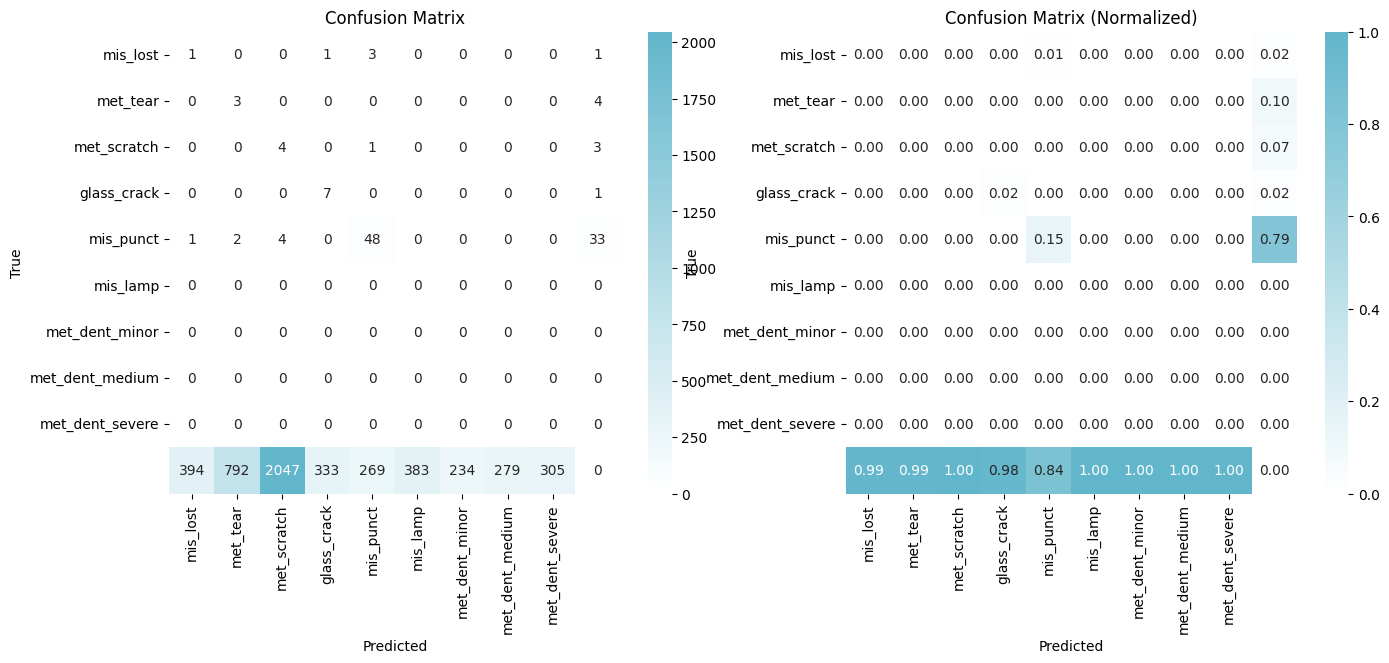

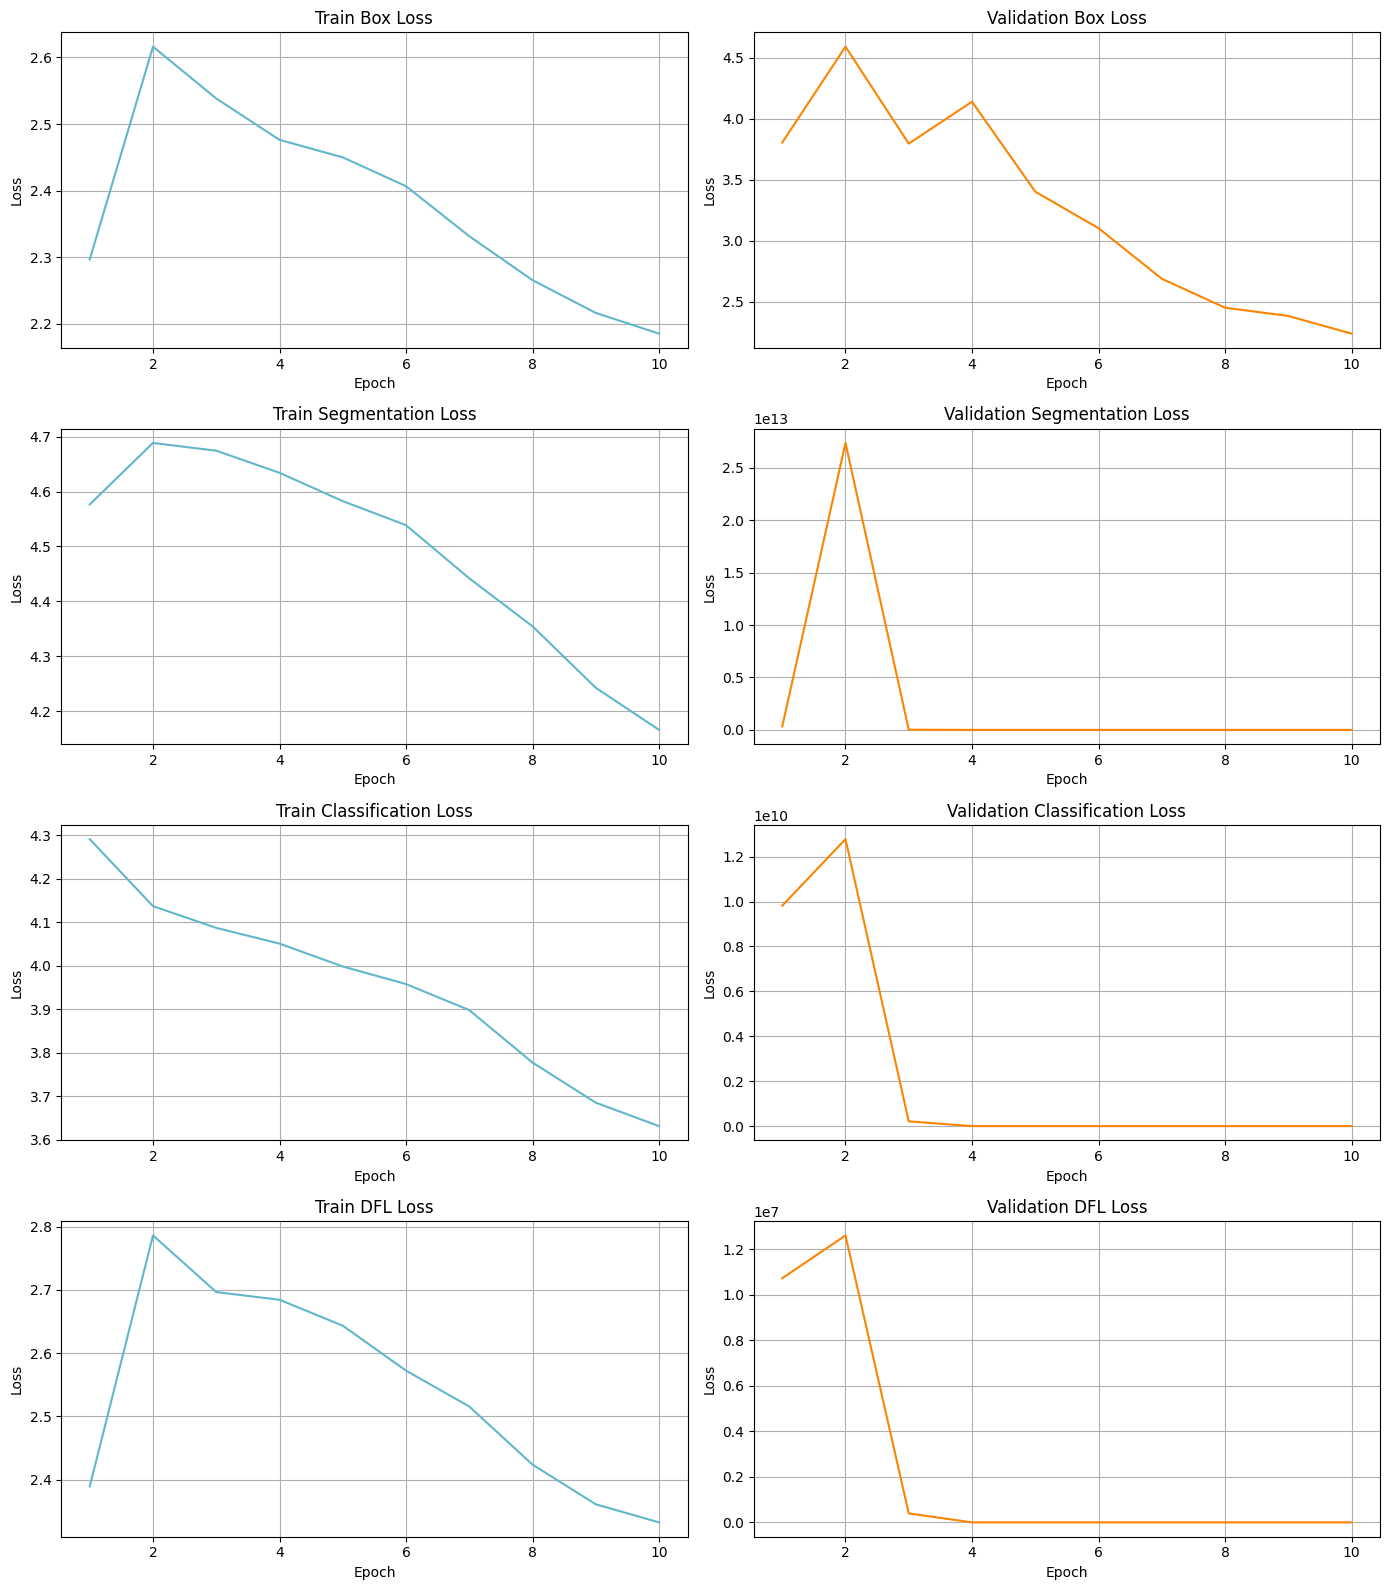

In [28]:
%matplotlib inline
# Validate the model
metrics_yolo(model = yolo_model,path_results_yolo = "./Models/runs/train", color1 = color1, color2 = color2)


In [ ]:
space = {
    'lr0': [0.001, 0.01],  # Initial learning rate
}

# Tune the model
model.tune(space=space, data='./Notebooks/data.yaml')

In [17]:
model.train(data="data.yaml", epochs=100, optimizer='Adam', task='segment')

# Path to save/load the model
model_path = "../Models/yolo_model.pkl"

# Fit the GLM with Gamma family and log link if it is not saved
if os.path.exists(model_path):
    print("Loading existing model...")
    yolo_model = joblib.load(model_path)
else:
    print("Training new model...")
    try:
        yolo_model = model.train(data="data.yaml", epochs=100, optimizer='Adam', task='segment')
        gb_model.fit(X_train, y_train)
        # Save the model
        joblib.dump(gb_model, model_path)
        print(f"Model saved to {model_path}")
    except Exception as e:
        print("Error fitting the model:", e)
        raise e

Tuner: Initialized Tuner instance with 'tune_dir=C:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa\runs\segment\tune9'
Tuner:  Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/10 with hyperparameters: {'lr0': 0.01}


In [9]:

! pip install -U ultralytics

In [8]:
! python.exe -m pip install --upgrade pip

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
    --------------------------------------- 0.0/1.8 MB 660.6 kB/s eta 0:00:03
   ---- ----------------------------------- 0.2/1.8 MB 2.0 MB/s eta 0:00:01
   -------- ------------------------------- 0.4/1.8 MB 3.1 MB/s eta 0:00:01
   ------------ --------------------------- 0.6/1.8 MB 3.0 MB/s eta 0:00:01
   ---------------- ----------------------- 0.8/1.8 MB 3.2 MB/s eta 0:00:01
   --------------------- ------------------ 1.0/1.8 MB 3.4 MB/s eta 0:00:01
   ------------------------ --------------- 1.1/1.8 MB 3.3 MB/s eta 0:00:01
   ------------------------------ --------- 1.4/1.8 MB 3.6 MB/s eta 0:00:01
   ----------------------------------- ---- 1.6/1.8 MB 3.8 MB/s eta 0:00:01
   ---------------------------------------  1.8/1.8 MB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 3.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24

In [19]:
results = model.predict("03bda226ad62553c0c73.jpg")


image 1/1 c:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa\03bda226ad62553c0c73.jpg: 480x640 300 met_scratchs, 501.6ms
Speed: 5.4ms preprocess, 501.6ms inference, 145.0ms postprocess per image at shape (1, 3, 480, 640)


In [34]:
results[0].masks

ultralytics.engine.results.Masks object with attributes:

data: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,

In [22]:
# Realizar predicciones
results = model.predict("03bda226ad62553c0c73.jpg", conf=0.9, iou=0.7)

# Visualizar resultados
for result in results:
    img = result.plot(show=True, labels=True, masks=True, boxes=True)
    plt.imshow(img)
    plt.show()


image 1/1 c:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa\03bda226ad62553c0c73.jpg: 480x640 132 met_scratchs, 412.3ms
Speed: 0.0ms preprocess, 412.3ms inference, 58.0ms postprocess per image at shape (1, 3, 480, 640)


<Figure size 640x480 with 1 Axes>